In [1]:
#importing the packages
import xarray as xr
import xclim as xc
import matplotlib.pyplot as plt
import numpy as np
import dask
import pandas as pd
from dask.distributed import performance_report, Client, progress
import datetime

In [2]:
#setting up dask 
client = Client()  # set up local cluster on your laptop
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 40,Total memory: 503.48 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36716,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 40
Started: Just now,Total memory: 503.48 GiB
Comm: tcp://127.0.0.1:44796,Total threads: 5
Dashboard: /proxy/36641/status,Memory: 62.94 GiB
Nanny: tcp://127.0.0.1:42953,


# Loading the dataset Data 

In [3]:
#creating the list of file links for temperature, precipitation, humidity and wind speed variables

wind_file_list = []
temp_file_list = []
prep_file_list = []
hum_file_list = []

for year in range(1990,2015):
    yr = str(year)
    wind_file = '/data/rsriver/c/davidcl2/METDATA/vs_' + yr + '.nc'
    temp_file = '/data/rsriver/c/davidcl2/METDATA/tmmx_' + yr + '.nc'
    prep_file = '/data/rsriver/c/davidcl2/METDATA/pr_' + yr + '.nc'
    hum_file = '/data/rsriver/c/davidcl2/METDATA/rmin_' + yr + '.nc'
    
    wind_file_list.append(wind_file)
    temp_file_list.append(temp_file)
    prep_file_list.append(prep_file)
    hum_file_list.append(hum_file)

In [4]:
#opening the datasets

wind_ds = xr.open_mfdataset(wind_file_list).sel(lat=32.7, lon=-117.16, method = 'nearest').compute()
temp_ds = xr.open_mfdataset(temp_file_list).sel(lat=32.7, lon=-117.16, method = 'nearest').compute()
prep_ds = xr.open_mfdataset(prep_file_list).sel(lat=32.7, lon=-117.16, method = 'nearest').compute()
hum_ds = xr.open_mfdataset(hum_file_list).sel(lat=32.7, lon=-117.16, method = 'nearest').compute()

In [5]:
#changing the units to be compatible with xclim package to calculate FWI

prep_ds.precipitation_amount.attrs['units'] = 'mm/day'

prep_ds = prep_ds.rename({'day':'time'})
temp_ds = temp_ds.rename({'day':'time'})
wind_ds = wind_ds.rename({'day':'time'})
hum_ds = hum_ds.rename({'day':'time'})

In [6]:
#Using xclim package to calculate Fire Weather Index

out = xc.indices.fire_weather_indexes(
    temp_ds.air_temperature,
    prep_ds.precipitation_amount,
    wind_ds.wind_speed,
    hum_ds.relative_humidity,
    hum_ds.lat)

In [7]:
#saving the FWI values

FWI_values = out[5]
FWI_values

<xarray.DataArray (time: 9131)>
array([ 0.7665876,  0.410674 ,  0.629529 , ..., 17.820805 ,  3.330079 ,
        6.7868876], dtype=float32)
Coordinates:
    lon      float64 -117.1
    lat      float64 32.69
  * time     (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2014-12-31
Attributes:
    units:

Text(0, 0.5, 'FWI')

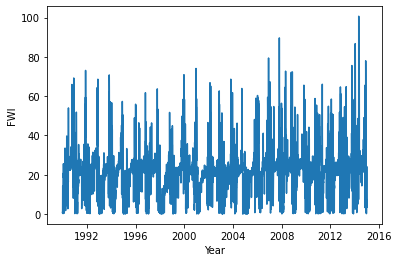

In [8]:
#plotting the overall timeseries

plt.plot(FWI_values.time,FWI_values)
plt.xlabel('Year')
plt.ylabel('FWI')

In [10]:
#calculating the yearly, monthly and daily average and maximum FWI values

FWI_daily_mean = FWI_values.groupby('time.dayofyear').mean().compute()
FWI_monthly_mean = FWI_values.groupby('time.month').mean().compute()
FWI_yearly_mean = FWI_values.groupby('time.year').mean().compute()

FWI_daily_max = FWI_values.groupby('time.dayofyear').max().compute()
FWI_monthly_max = FWI_values.groupby('time.month').max().compute()
FWI_yearly_max = FWI_values.groupby('time.year').max().compute()

Text(0.5, 1.0, 'Yearly mean FWI')

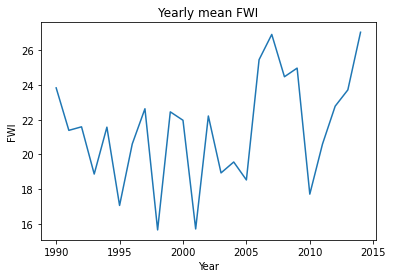

In [10]:
# Plotting average yearly FWI

plt.plot(FWI_yearly_mean.year,FWI_yearly_mean)
plt.xlabel('Year')
plt.ylabel('FWI')
plt.title('Yearly mean FWI')

Text(0.5, 1.0, 'Yearly max FWI')

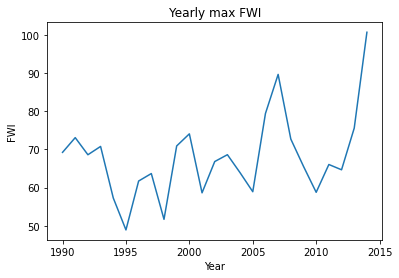

In [11]:
# Plotting yearly maximum FWI values

plt.plot(FWI_yearly_max.year,FWI_yearly_max)
plt.xlabel('Year')
plt.ylabel('FWI')
plt.title('Yearly max FWI')

Text(0.5, 1.0, 'Monthly mean FWI')

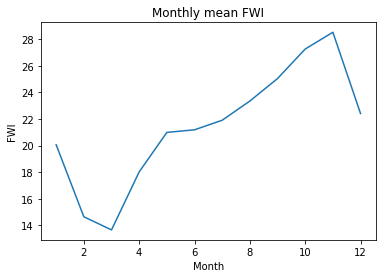

In [12]:
# Plotting monthky average FWI values

plt.plot(FWI_monthly_mean.month,FWI_monthly_mean)
plt.xlabel('Month')
plt.ylabel('FWI')
plt.title('Monthly mean FWI')

Text(0.5, 1.0, 'Monthly max FWI')

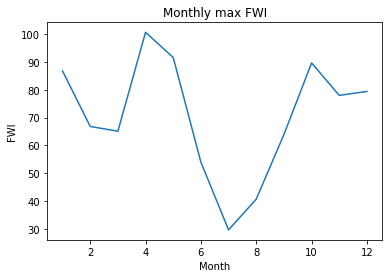

In [13]:
# Plotting monthly maximum FWI values

plt.plot(FWI_monthly_max.month,FWI_monthly_max)
plt.xlabel('Month')
plt.ylabel('FWI')
plt.title('Monthly max FWI')

Text(0.5, 1.0, 'Daily Mean FWI')

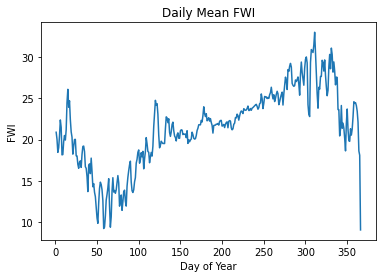

In [14]:
# Plotting daily average FWI values

plt.plot(FWI_daily_mean.dayofyear,FWI_daily_mean)
plt.xlabel('Day of Year')
plt.ylabel('FWI')
plt.title('Daily Mean FWI')

Text(0.5, 1.0, 'Daily Max FWI')

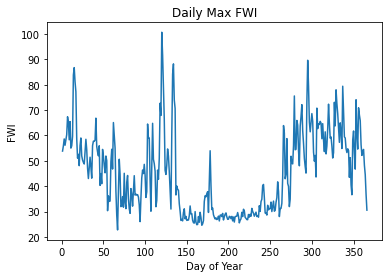

In [15]:
# Plotting daily maximum FWI values

plt.plot(FWI_daily_max.dayofyear,FWI_daily_max)
plt.xlabel('Day of Year')
plt.ylabel('FWI')
plt.title('Daily Max FWI')

In [11]:
#Deseasoning the FWI values
FWI_deseason = FWI_values.groupby('time.month') - FWI_monthly_mean
FWI_deseason

<xarray.DataArray (time: 9131)>
array([-19.291964 , -19.647879 , -19.429024 , ...,  -4.5870075,
       -19.077732 , -15.620924 ], dtype=float32)
Coordinates:
    lon      float64 -117.1
    lat      float64 32.69
  * time     (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2014-12-31
    month    (time) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12 12

In [12]:
FWI_deseasoned = FWI_deseason.drop('month', dim=None) #dropping the month coordinate
FWI_deseasoned #deseasoned dataset

<xarray.DataArray (time: 9131)>
array([-19.291964 , -19.647879 , -19.429024 , ...,  -4.5870075,
       -19.077732 , -15.620924 ], dtype=float32)
Coordinates:
    lon      float64 -117.1
    lat      float64 32.69
  * time     (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2014-12-31

In [13]:
#Detrending the FWI values
def detrend_dim(da, dim, deg=1): #treating a function to detrend
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit


FWI_detrend = xr.Dataset()
FWI_detrend['FWI'] = detrend_dim(FWI_deseasoned, 'time')
FWI_detrend

<xarray.Dataset>
Dimensions:  (time: 9131)
Coordinates:
    lon      float64 -117.1
    lat      float64 32.69
  * time     (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2014-12-31
Data variables:
    FWI      (time) float64 -17.5 -17.86 -17.64 -9.871 ... -6.375 -20.87 -17.41

In [14]:
#Standardizing the FWI values
climatology_mean = FWI_detrend.groupby('time.month').mean('time') 
climatology_std = FWI_detrend.groupby('time.month').std('time')

FWI_stand = xr.apply_ufunc( lambda x, m, s: (x - m) / s,
                            FWI_detrend.groupby('time.month'),
                            climatology_mean, climatology_std)
FWI_stand

<xarray.Dataset>
Dimensions:  (time: 9131)
Coordinates:
    lon      float64 -117.1
    lat      float64 32.69
  * time     (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2014-12-31
    month    (time) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12 12
Data variables:
    FWI      (time) float64 -1.097 -1.12 -1.106 -0.6206 ... -0.4247 -1.4 -1.167

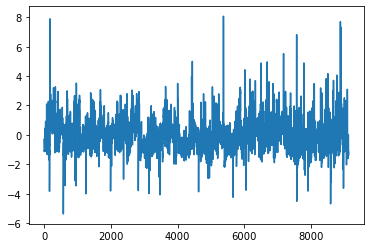

In [15]:
plt.plot(FWI_stand.FWI)

# Fitting models 

In [16]:
#Creating a pandas dataframe with all the values
dataset = pd.DataFrame()

dataset.index = FWI_values.time.values
dataset['Temp'] = temp_ds.air_temperature.values
dataset['Prep'] = prep_ds.precipitation_amount.values
dataset['Wind'] = wind_ds.wind_speed.values
dataset['Hum'] = hum_ds.relative_humidity.values
dataset['FWI'] = FWI_values
dataset['FWI_Stand'] = FWI_stand.FWI

In [17]:
dataset

,Temp,Prep,Wind,Hum,FWI,FWI_Stand
1990-01-01,291.274994,3.084586,3.036671,26.018539,0.766588,-1.097335
1990-01-02,287.315094,8.940436,5.290934,44.515465,0.410674,-1.119589
1990-01-03,290.535004,0.000000,1.529485,37.928535,0.629529,-1.105944
1990-01-04,290.294952,0.000000,3.755102,15.715921,8.399940,-0.620642
1990-01-05,292.845184,0.000000,3.808899,19.294901,11.949210,-0.398985
...,...,...,...,...,...,...
2014-12-27,289.424469,0.000000,3.401248,14.728878,23.803524,-0.021917
2014-12-28,289.495117,0.000000,1.999869,21.126431,20.616041,-0.236498
2014-12-29,290.045258,0.000000,2.034082,35.765167,17.820805,-0.424676
2014-12-30,288.084442,2.309408,3.535644,59.505733,3.330079,-1.400097


In [18]:
#creating the x and y datadrames

x = dataset.iloc[:,0:4]  #storing the climate parameters as x
y = dataset.iloc[:,4]   #storing the FWI values as y
y_stand = dataset.iloc[:,5]  #storing the standardized FWI values as y_stand

In [19]:
#importing the train_test_split to split the data. 
from sklearn.model_selection import train_test_split

#spliting 80% data to training and 20% to testing data 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=0)

In [20]:
x_train

,Temp,Prep,Wind,Hum
2010-09-23,294.984955,0.000000,1.669666,52.465240
2011-01-04,289.633820,0.000000,1.877861,48.519348
2009-11-09,293.188934,0.000000,1.878663,49.998524
1995-10-26,294.178711,0.000000,1.206536,57.644608
1991-04-25,289.128937,0.000000,3.892158,62.866123
...,...,...,...,...
2001-12-22,290.436707,0.000000,2.330955,49.888752
2011-08-10,296.203766,0.000000,2.386420,58.115513
2003-04-22,286.761932,0.822576,4.462548,70.172142
1998-12-09,292.087341,0.000000,4.328301,18.368093


In [21]:
#creating a function to caluclate the RMSE and R^2 score for different models 

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

def error(actual, pred):
    rmse = sqrt(mean_squared_error(actual, pred))
    r2 = r2_score(actual, pred)
    print('RMSE for this model:', rmse)
    print('R^2 score for this model:', r2)

MultiLinear Regression

In [22]:
#MultiLinear Regression model 
from sklearn.linear_model import LinearRegression
model_linear = LinearRegression(fit_intercept=True)

model_linear.fit(x_train, y_train)

y_test_linear_pred = model_linear.predict(x_test)

error(actual = y_test, pred = y_test_linear_pred)

RMSE for this model: 7.301752261621035
R^2 score for this model: 0.6020870925505819


Polynomial Regression

In [23]:
#polynomial regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

#making a pipeline for polynomial regression
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

#importing GridSearchCV
from sklearn.model_selection import GridSearchCV

#defining the parameter grid and grid search 
param_grid = {'polynomialfeatures__degree': [2,3,4,5,6,7,8,9]}

poly_grid = GridSearchCV(PolynomialRegression(), param_grid, scoring= 'r2',
                         error_score = 'raise', cv=7) #finding the best model in terms of R^2

In [24]:
#fitting polynomial regression
poly_grid.fit(x_train, y_train)
poly_grid.best_params_

{'polynomialfeatures__degree': 7}

In [25]:
#predicting the test data for the best model found in the grid search
poly_model = poly_grid.best_estimator_

#predicting and getting the error terms
y_test_poly_pred = poly_model.fit(x_train, y_train).predict(x_test)
error(actual = y_test, pred = y_test_poly_pred)

RMSE for this model: 6.452965981507735
R^2 score for this model: 0.6892203065397398


KNN Regression

In [26]:
#Fitting KNN Regressor
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}

from sklearn import neighbors
knn = neighbors.KNeighborsRegressor()

knn_grid = GridSearchCV(knn, params, cv=5)
knn_grid.fit(x_train,y_train)
knn_grid.best_params_

{'n_neighbors': 13}

In [27]:
#Fitting KNN and getting the errors
knn_model = knn_grid.best_estimator_

y_test_knn_pred = knn_model.fit(x_train, y_train).predict(x_test)
error(actual = y_test, pred = y_test_knn_pred)

RMSE for this model: 6.7018105523026446
R^2 score for this model: 0.6647890954394207


Random Forest Regression

In [28]:
#importing and defining a Random Forest Regression model
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(50)

#defining the parameter grid using the values given in the question
random_param_grid = {'bootstrap': [True, False],  
                        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],  
                        'max_features': ['auto', 'sqrt'],  
                        'min_samples_leaf': [1, 2, 4],  
                        'min_samples_split': [2, 5, 10],  
                        'n_estimators': [200, 400, 600, 800, 1000]}

In [29]:
#Fitting the Random Forest regressor 
from sklearn.model_selection import RandomizedSearchCV

forest_grid = RandomizedSearchCV(estimator = forest, param_distributions= random_param_grid, scoring= 'r2')
forest_grid.fit(x_train, y_train)

CPU times: user 8 µs, sys: 8 µs, total: 16 µs
Wall time: 33.9 µs


RandomizedSearchCV(estimator=RandomForestRegressor(n_estimators=50),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   scoring='r2')

In [30]:
#Getting the error terms
forest_grid.best_params_
forest_model = forest_grid.best_estimator_

y_test_forest_pred = forest_model.fit(x_train, y_train).predict(x_test)
error(actual = y_test, pred = y_test_forest_pred)

RMSE for this model: 6.449385189007488
R^2 score for this model: 0.6895651447568032


In [31]:
#Getting the feature importances from Random Forest model
forest_model.feature_importances_

array([0.21425049, 0.22211534, 0.05393089, 0.50970328])

<BarContainer object of 4 artists>

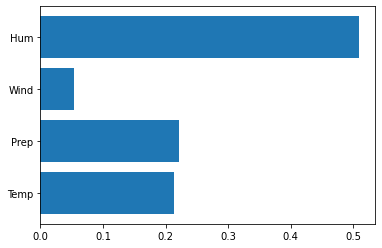

In [32]:
#Plotting the feature importances
plt.barh(x.columns,forest_model.feature_importances_)

# For Standardized FWI values

We repeat the model fitting process using the Standardized FWI values as the target variable.

In [33]:
#importing the train_test_split to split the data. 
from sklearn.model_selection import train_test_split

#spliting 80% data to training and 80% to testing data 
x_train2, x_test2, y_train2, y_test2 = train_test_split(x, y_stand, test_size = 0.2, random_state=0)

Multilinear Regression

In [34]:
#MultiLinear Regression model 
from sklearn.linear_model import LinearRegression
model_linear = LinearRegression(fit_intercept=True)

model_linear.fit(x_train2, y_train2)

y_test_linear_pred2 = model_linear.predict(x_test2)

error(actual = y_test2, pred = y_test_linear_pred2)

RMSE for this model: 0.7078435447947866
R^2 score for this model: 0.5176475309982898


Polynomial Regression

In [35]:
#Using the grid to find the optimal degree
poly_grid2 = GridSearchCV(PolynomialRegression(), param_grid, scoring= 'r2',
                         error_score = 'raise', cv=7)
poly_grid2.fit(x_train2, y_train2)
poly_grid2.best_params_

{'polynomialfeatures__degree': 5}

In [36]:
#predicting the test data for the best model found in the grid search
poly_model2 = poly_grid2.best_estimator_

y_test_poly_pred2 = poly_model2.fit(x_train2, y_train2).predict(x_test2)
error(actual = y_test2, pred = y_test_poly_pred2) #getting the test errors

RMSE for this model: 0.6457056421880263
R^2 score for this model: 0.5986168686320414


KNN Regression

In [37]:
#KNN Regressor

knn_grid2 = GridSearchCV(knn, params, cv=5)
knn_grid2.fit(x_train2,y_train2)
knn_grid2.best_params_

{'n_neighbors': 15}

In [38]:
#Predicting and calculating error terms for KNN regressor

knn_model2 = knn_grid2.best_estimator_

y_test_knn_pred2 = knn_model2.fit(x_train2, y_train2).predict(x_test2)
error(actual = y_test2, pred = y_test_knn_pred2)

RMSE for this model: 0.6676897641541091
R^2 score for this model: 0.5708200833743455


Random Forest Regression

In [39]:
#Fitting the random forest grid

forest_grid2 = RandomizedSearchCV(estimator = forest, param_distributions= random_param_grid, scoring= 'r2')
forest_grid2.fit(x_train2, y_train2)

RandomizedSearchCV(estimator=RandomForestRegressor(n_estimators=50),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   scoring='r2')

In [40]:
#Preditcting and getting the error terms using Random Forest grid.

forest_model2 = forest_grid2.best_estimator_

y_test_forest_pred2 = forest_model2.fit(x_train2, y_train2).predict(x_test2)
error(actual = y_test2, pred = y_test_forest_pred2)

RMSE for this model: 0.6114808882398644
R^2 score for this model: 0.6400387678846863


In [41]:
#Getting the feature importance

forest_model2.feature_importances_

array([0.2094035 , 0.17415866, 0.11385375, 0.50258409])

<BarContainer object of 4 artists>

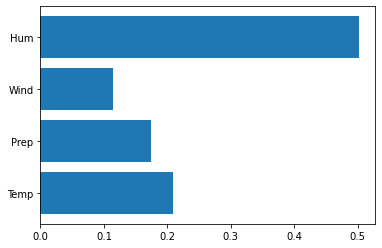

In [42]:
#Plotting the feature importances

plt.barh(x_train2.columns,forest_model2.feature_importances_)

# FWI values with one hot encoding

We repeat the model fitting process using one hot encoding for the month of time.

In [43]:
#One hot encoding for month 

x_new = x
x_new['month'] = x.index.month
x_new = pd.get_dummies(x_new, columns = ['month'])

In [44]:
#spliting 80% data to training and 20% to testing data 

x_train3, x_test3, y_train3, y_test3 = train_test_split(x_new, y, test_size = 0.2, random_state=0)

Multilinear Regression

In [45]:
#MultiLinear Regression model

model_linear = LinearRegression(fit_intercept=True)

model_linear.fit(x_train3, y_train3)

y_test_linear_pred3 = model_linear.predict(x_test3)

error(actual = y_test3, pred = y_test_linear_pred3)

RMSE for this model: 6.515800638370113
R^2 score for this model: 0.6831385574014732


KNN Regression

In [46]:
#KNN regression

knn_grid3 = GridSearchCV(knn, params, cv=5)
knn_grid3.fit(x_train3,y_train3)
knn_grid3.best_params_

{'n_neighbors': 9}

In [47]:
#Predicting and getting erros for KNN regression

knn_model3 = knn_grid3.best_estimator_

y_test_knn_pred3 = knn_model3.fit(x_train3, y_train3).predict(x_test3)
error(actual = y_test3, pred = y_test_knn_pred3)

RMSE for this model: 6.228823376980688
R^2 score for this model: 0.7104351346690052


Random Forest Regressor

In [48]:
#Fitting the random forest grid
from sklearn.model_selection import RandomizedSearchCV

forest_grid3 = RandomizedSearchCV(estimator = forest, param_distributions= random_param_grid, scoring= 'r2')
forest_grid3.fit(x_train3, y_train3)

RandomizedSearchCV(estimator=RandomForestRegressor(n_estimators=50),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   scoring='r2')

In [49]:
#Predicting and getting the test errors
forest_model3 = forest_grid3.best_estimator_

y_test_forest_pred3 = forest_model3.fit(x_train3, y_train3).predict(x_test3)
error(actual = y_test3, pred = y_test_forest_pred3)

RMSE for this model: 5.789489221676227
R^2 score for this model: 0.7498420294140362


In [50]:
#Getting the feature importances
forest_model3.feature_importances_

array([0.22080985, 0.1515878 , 0.09980353, 0.42455928, 0.00870922,
       0.01409136, 0.02404774, 0.00699173, 0.00458353, 0.00180915,
       0.00128956, 0.00145954, 0.00451104, 0.01285512, 0.01702923,
       0.00586231])

<BarContainer object of 16 artists>

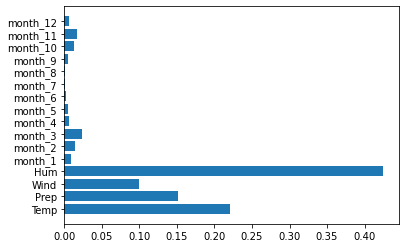

In [51]:
#Plotting the feature importances
plt.barh(x_train3.columns,forest_model3.feature_importances_)